In [1]:
%pip install torchviz
%pip install torchsummary
import torch
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
from torchviz import make_dot, make_dot_from_trace
from torchvision import models
from sklearn.metrics import confusion_matrix

import os
import librosa
from scipy.io import wavfile
import numpy as np
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

Running on cpu.


### Get Data

In [3]:
clean_train_dir = "./MS-SNSD/CleanSpeech_training/"

In [4]:
SRATE = 16000

In [5]:
df_clean_train = os.listdir(clean_train_dir)

len(df_clean_train)

158

In [6]:
test = librosa.load("./MS-SNSD/CleanSpeech_training/clnsp1.wav")

librosa.get_samplerate("./MS-SNSD/CleanSpeech_training/clnsp1.wav")

16000

In [7]:


clean_speech_dir = "./MS-SNSD/CleanSpeech_training/"
clean_speech = os.listdir(clean_speech_dir)

noise_dir = "./MS-SNSD/Noise_training/"
noise = os.listdir(noise_dir)

noisy_speech_dir = "./MS-SNSD/NoisySpeech_training/"
noisy_speech = os.listdir(noisy_speech_dir)

len(clean_speech), len(noise), len(noisy_speech)

(158, 158, 158)

In [8]:


num_seconds = 10

data, srate = librosa.load(path=clean_speech_dir + clean_speech[0], sr=SRATE)
# X = torch.empty((len(noisy_speech) + len(clean_speech), srate*num_seconds))
# mels = librosa.feature.melspectrogram(y=data, sr=srate)
# mels
# data
mels = librosa.feature.melspectrogram(y=data, sr=srate)

mels.shape

(128, 326)

In [9]:
mels[0]

array([3.98465246e-01, 4.80970174e-01, 8.97565365e-01, 1.48414254e+00,
       8.48001480e-01, 4.86533165e-01, 2.02708101e+00, 1.61943996e+00,
       4.32237357e-01, 3.03288609e-01, 2.82783329e-01, 1.05572271e+00,
       1.42393148e+00, 1.04234982e+00, 5.53677142e-01, 2.53279746e-01,
       5.73919900e-02, 3.97126041e-02, 2.49428183e-01, 4.97550309e-01,
       4.76593703e-01, 1.17111735e-01, 1.81969628e-01, 2.40263805e-01,
       2.16154027e+00, 3.62914896e+00, 1.69083011e+00, 3.01510543e-01,
       5.43841481e-01, 5.19731879e-01, 6.71075881e-01, 8.27052951e-01,
       3.61248136e-01, 4.67705667e-01, 1.05518627e+00, 5.52994609e-01,
       7.43618369e-01, 1.18504369e+00, 7.24396706e-01, 5.66454470e-01,
       3.33180696e-01, 2.80467033e-01, 4.56945956e-01, 3.49966764e-01,
       6.16904557e-01, 1.19434083e+00, 1.58934546e+00, 7.14424014e-01,
       1.14676297e+00, 5.68362474e-01, 2.69955814e-01, 2.88143903e-01,
       6.51368856e-01, 1.03198957e+00, 4.72522765e-01, 8.80708471e-02,
      

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

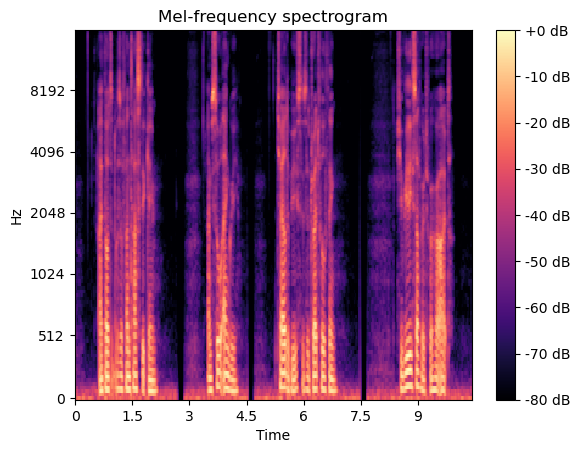

In [10]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mels, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=srate,
                         fmax=16000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [11]:
S_dB.shape

(128, 326)

In [12]:
data, srate = librosa.load(path=noisy_speech_dir + noisy_speech[0], sr=SRATE)
data = data[:srate*10]
mels = librosa.feature.melspectrogram(y=data, sr=srate)
S_dB = librosa.power_to_db(mels, ref=np.max)
S_dB

array([[-28.070843, -25.74665 , -26.17147 , ..., -22.19036 , -21.687853,
        -22.594835],
       [-31.923716, -35.17703 , -31.246193, ..., -31.954372, -29.713455,
        -28.502083],
       [-34.820816, -37.541443, -37.40686 , ..., -29.869404, -26.494514,
        -33.000084],
       ...,
       [-68.41077 , -61.7137  , -61.510445, ..., -56.91076 , -58.92724 ,
        -61.394135],
       [-67.934845, -61.926888, -62.01873 , ..., -59.142487, -64.00177 ,
        -62.512367],
       [-69.815475, -63.20211 , -62.427498, ..., -59.584198, -63.17083 ,
        -61.832954]], dtype=float32)

In [13]:
# create our torch tensor X

X = torch.empty((len(noisy_speech) + len(clean_speech), S_dB.shape[0], S_dB.shape[1]))

In [14]:
for i in range(0, len(noisy_speech)):
    data, srate = librosa.load(noisy_speech_dir + noisy_speech[i], sr=SRATE)
    data = data[:srate*10]
    mels = librosa.feature.melspectrogram(y=data, sr=srate)
    S_dB = librosa.power_to_db(mels, ref=np.max)

    X[i] = torch.tensor(S_dB)

    i += 1

X

tensor([[[-28.0708, -25.7467, -26.1715,  ..., -22.1904, -21.6879, -22.5948],
         [-31.9237, -35.1770, -31.2462,  ..., -31.9544, -29.7135, -28.5021],
         [-34.8208, -37.5414, -37.4069,  ..., -29.8694, -26.4945, -33.0001],
         ...,
         [-68.4108, -61.7137, -61.5104,  ..., -56.9108, -58.9272, -61.3941],
         [-67.9348, -61.9269, -62.0187,  ..., -59.1425, -64.0018, -62.5124],
         [-69.8155, -63.2021, -62.4275,  ..., -59.5842, -63.1708, -61.8330]],

        [[-37.9657, -34.1486, -34.5822,  ..., -30.4063, -32.7871, -31.9506],
         [-32.6354, -26.9268, -29.0086,  ..., -32.0342, -32.1263, -32.8163],
         [-33.4748, -26.6366, -26.6088,  ..., -25.8342, -26.3297, -26.1385],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -31.2318, -39.6793, -46.2323],
         [-80.0000, -80.0000, -80.0000,  ..., -32.0770, -38.1502, -43.8875],
         [-80.0000, -80.0000, -80.0000,  ..., -31.6545, -38.5559, -44.6627]],

        [[-40.9851, -38.6183, -37.7892,  ...

In [15]:
for i in range(len(noisy_speech), len(noisy_speech) + len(clean_speech)): 
    # can grab more from just the clean_train folder, but right now I'm just grabbing what formed the training data
    data, srate = librosa.load(clean_speech_dir + clean_speech[i - len(noisy_speech)], sr=SRATE)
    data = data[:srate*10]
    mels = librosa.feature.melspectrogram(y=data, sr=srate)
    S_dB = librosa.power_to_db(mels, ref=np.max)

    X[i] = torch.tensor(S_dB)

    i += 1
X

tensor([[[-28.0708, -25.7467, -26.1715,  ..., -22.1904, -21.6879, -22.5948],
         [-31.9237, -35.1770, -31.2462,  ..., -31.9544, -29.7135, -28.5021],
         [-34.8208, -37.5414, -37.4069,  ..., -29.8694, -26.4945, -33.0001],
         ...,
         [-68.4108, -61.7137, -61.5104,  ..., -56.9108, -58.9272, -61.3941],
         [-67.9348, -61.9269, -62.0187,  ..., -59.1425, -64.0018, -62.5124],
         [-69.8155, -63.2021, -62.4275,  ..., -59.5842, -63.1708, -61.8330]],

        [[-37.9657, -34.1486, -34.5822,  ..., -30.4063, -32.7871, -31.9506],
         [-32.6354, -26.9268, -29.0086,  ..., -32.0342, -32.1263, -32.8163],
         [-33.4748, -26.6366, -26.6088,  ..., -25.8342, -26.3297, -26.1385],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -31.2318, -39.6793, -46.2323],
         [-80.0000, -80.0000, -80.0000,  ..., -32.0770, -38.1502, -43.8875],
         [-80.0000, -80.0000, -80.0000,  ..., -31.6545, -38.5559, -44.6627]],

        [[-40.9851, -38.6183, -37.7892,  ...

In [16]:
y = torch.empty((len(noisy_speech) + len(clean_speech)), dtype=torch.long)
for i in range(0, y.shape[0]):
    y[i] = 1 if i < len(noisy_speech) else 0
y

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
# divide data into train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, test_size = 0.2)

### Data Loaders

In [18]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size = 32,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val),
    batch_size = 32,
    shuffle = True
)

In [19]:
X_dl, y_dl = next(iter(data_loader_train))
print(X_dl.size(), y_dl.size())

torch.Size([32, 128, 313]) torch.Size([32])


In [20]:
next(iter(data_loader_train))

[tensor([[[-31.4153, -29.7252, -26.2726,  ..., -24.6099, -24.6762, -31.0075],
          [-34.2764, -32.6259, -31.2280,  ..., -25.5244, -27.0752, -29.5632],
          [-28.5567, -28.1799, -26.7888,  ..., -24.1599, -26.2317, -31.0460],
          ...,
          [-55.9879, -47.3810, -45.7104,  ..., -46.3459, -50.0024, -53.3086],
          [-53.9262, -50.3312, -50.0565,  ..., -45.2901, -47.7450, -52.3311],
          [-54.6613, -52.5083, -51.8242,  ..., -47.5929, -49.8114, -54.3608]],
 
         [[-36.2963, -19.0535, -14.4753,  ..., -18.3762, -17.6045, -13.2667],
          [-42.0930, -34.9228, -38.0771,  ..., -30.7956, -28.3446, -22.8983],
          [-50.1352, -40.7877, -41.2371,  ..., -35.6701, -29.2056, -27.2288],
          ...,
          [-80.0000, -80.0000, -80.0000,  ..., -56.1935, -57.1862, -56.8572],
          [-80.0000, -80.0000, -80.0000,  ..., -53.1242, -55.0183, -57.8888],
          [-80.0000, -80.0000, -80.0000,  ..., -53.6759, -55.8056, -58.3486]],
 
         [[-31.8002, -26.139

Sample loading data from the Data Loader:

In [21]:
print(X_train.size(), y_train.size())

torch.Size([252, 128, 313]) torch.Size([252])


In [22]:
S_dB.shape

(128, 313)

In [38]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*313, 2)
        )

    # this is the customary name for the method that computes the scores
    # the loss is usually computed outside the model class during the training loop
    def forward(self, x):
        return self.pipeline(x)

    def predict(self, x):

        scores = self.forward(x)
        return torch.argmax(scores, dim = 1)

model = LinearModel().to(device)

Construct a summary so that we can see what happens to the data in each layer of the pipeline

In [27]:
from torchsummary import summary
summary(model, input_size=(128, 313))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 40064]               0
            Linear-2                    [-1, 2]          80,130
Total params: 80,130
Trainable params: 80,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 0.31
Params size (MB): 0.31
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


In [28]:
def evaluate(model, X, y, multichannel=False):
  # start counting total observations and correct predictions
  total = 0
  total_correct = 0

  # for X, y in data_loader_val:

  X, y = X.to(device), y.to(device)

  scores = model.forward(X)
  y_pred = torch.argmax(scores, dim = 1)

  total += X.size(0)
  total_correct += (y_pred == y).sum().item()

  print(f"validation accuracy = {total_correct / total:.3f}")

In [39]:
import torch.optim as optim
def train(model, X, y, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

        # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))
            X, y = X.to(device), y.to(device)

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            # print(type(y_pred[0][0].item()))
            # print(type(y[0].item()))

            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model, X, y, multichannel = multichannel)

In [40]:
train(model, X_train, y=y_train, k_epochs=10)

RuntimeError: Given groups=1, weight of size [100, 1, 5, 5], expected input[1, 32, 128, 313] to have 1 channels, but got 32 channels instead

In [33]:
# create and load X and y vals (train test split like the text verification, testing data)
evaluate(model, X_val, y_val)

validation accuracy = 0.656
